In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 5.5
fig_height = 3.5
fig_format = :pdf
fig_dpi = 300

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/vituri/Documentos/GitHub/blog/posts/symbolic regression"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


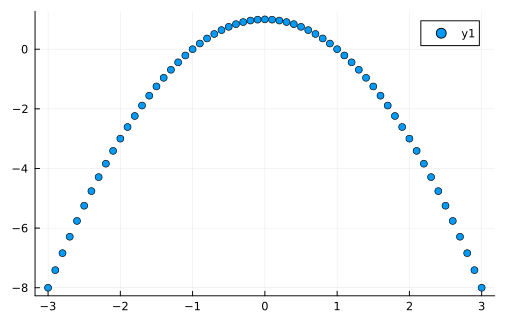

In [2]:
using SymbolicRegression, MLJ, SymbolicUtils
using Plots

x = [-3:0.1:3;]
y = @. - x^2 + 1;

scatter(x, y)

In [3]:
model = SRRegressor(
    binary_operators=[+, -, *],    
    niterations=50,
    seed = 1
);

In [4]:
#| output: false
X = reshape(x, (length(x), 1))

mach = machine(model, X, y)
fit!(mach)

[ Info: Training machine(SRRegressor(binary_operators = Function[+, -, *], …), …).
┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


0.0%┣                                             ┫ 0/750 [00:00<-1:-36, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           1.043e+01  3.604e+01  y = -0.44276                                  3           8.261e+00  1.165e-01  y = (-0.89606 + -0.44276)                     7           2.779e+00  2.724e-01  y = ((x₁ * x₁) * (-0.89606 - -0.44276))       11          1.038e+00  2.462e-01  y = ((x₁ * x₁) * ((x₁ - 0.73065) + (0.095228 - x₁)))                                                                          13          1.611e-01  9.314e-01  y = ((

2.4%┣█                                            ┫ 18/750 [00:00<00:14, 52it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.5%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


3.9%┣█▊                                           ┫ 29/750 [00:00<00:10, 72it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.7%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
5.1%┣██▎                                          ┫ 38/750 [00:00<00:09, 83it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.7%         Press 'q' and then <

6.1%┣██▊                                          ┫ 46/750 [00:01<00:08, 89it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.7%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
7.2%┣███▎                                         ┫ 54/750 [00:01<00:07, 95it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.6%         Press 'q' and then <

8.3%┣███▊                                         ┫ 62/750 [00:01<00:07, 99it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.7%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


9.2%┣████                                        ┫ 69/750 [00:01<00:07, 101it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.7%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
10.3%┣████▍                                      ┫ 77/750 [00:01<00:07, 103it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.7%         Press 'q' and then <

11.3%┣████▉                                      ┫ 85/750 [00:01<00:06, 106it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.7%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
12.4%┣█████▎                                     ┫ 93/750 [00:01<00:06, 107it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.7%         Press 'q' and then <

13.5%┣█████▋                                    ┫ 101/750 [00:01<00:06, 109it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.7%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
14.5%┣██████                                    ┫ 109/750 [00:01<00:06, 111it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.7%         Press 'q' and then <

15.6%┣██████▌                                   ┫ 117/750 [00:01<00:06, 112it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


16.7%┣███████                                   ┫ 125/750 [00:01<00:05, 114it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
17.7%┣███████▌                                  ┫ 133/750 [00:01<00:05, 115it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.7%        Press 'q' and then <

18.8%┣████████                                  ┫ 141/750 [00:01<00:05, 116it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
20.0%┣████████▍                                 ┫ 150/750 [00:01<00:05, 117it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.7%        Press 'q' and then <

21.2%┣█████████                                 ┫ 159/750 [00:01<00:05, 118it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
22.4%┣█████████▍                                ┫ 168/750 [00:01<00:05, 120it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.7%        Press 'q' and then <

23.6%┣██████████                                ┫ 177/750 [00:01<00:05, 121it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


24.7%┣██████████▍                               ┫ 185/750 [00:02<00:05, 122it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
25.7%┣██████████▉                               ┫ 193/750 [00:02<00:05, 123it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.7%        Press 'q' and then <

26.8%┣███████████▎                              ┫ 201/750 [00:02<00:04, 123it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
27.9%┣███████████▊                              ┫ 209/750 [00:02<00:04, 123it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.7%        Press 'q' and then <

28.8%┣████████████                              ┫ 216/750 [00:02<00:04, 123it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


29.7%┣████████████▌                             ┫ 223/750 [00:02<00:04, 122it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
30.8%┣█████████████                             ┫ 231/750 [00:02<00:04, 122it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.6%        Press 'q' and then <

31.7%┣█████████████▎                            ┫ 238/750 [00:02<00:04, 121it/s]Expressions evaluated per second: 1.67e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
32.7%┣█████████████▊                            ┫ 245/750 [00:02<00:04, 121it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.6%        Press 'q' and then <

33.6%┣██████████████▏                           ┫ 252/750 [00:02<00:04, 121it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


34.4%┣██████████████▌                           ┫ 258/750 [00:02<00:04, 120it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
35.2%┣██████████████▉                           ┫ 264/750 [00:02<00:04, 119it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.5%        Press 'q' and then <

36.1%┣███████████████▏                          ┫ 271/750 [00:02<00:04, 119it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
37.1%┣███████████████▋                          ┫ 278/750 [00:02<00:04, 119it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.6%        Press 'q' and then <

37.9%┣████████████████                          ┫ 284/750 [00:02<00:04, 118it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


38.7%┣████████████████▎                         ┫ 290/750 [00:02<00:04, 118it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
39.5%┣████████████████▋                         ┫ 296/750 [00:03<00:04, 117it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.5%        Press 'q' and then <

40.1%┣████████████████▉                         ┫ 301/750 [00:03<00:04, 116it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


40.8%┣█████████████████▏                        ┫ 306/750 [00:03<00:04, 115it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
41.6%┣█████████████████▌                        ┫ 312/750 [00:03<00:04, 114it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.7%        Press 'q' and then <

42.4%┣█████████████████▉                        ┫ 318/750 [00:03<00:04, 113it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
43.2%┣██████████████████▏                       ┫ 324/750 [00:03<00:04, 113it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.7%        Press 'q' and then <

44.3%┣██████████████████▋                       ┫ 332/750 [00:03<00:04, 113it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


45.1%┣███████████████████                       ┫ 338/750 [00:03<00:04, 113it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
46.0%┣███████████████████▎                      ┫ 345/750 [00:03<00:04, 113it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.7%        Press 'q' and then <

46.8%┣███████████████████▋                      ┫ 351/750 [00:03<00:04, 112it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


47.6%┣████████████████████                      ┫ 357/750 [00:03<00:04, 112it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
48.4%┣████████████████████▎                     ┫ 363/750 [00:03<00:03, 112it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.6%        Press 'q' and then <

49.1%┣████████████████████▋                     ┫ 368/750 [00:03<00:03, 111it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
50.0%┣█████████████████████                     ┫ 375/750 [00:03<00:03, 111it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.6%        Press 'q' and then <

50.7%┣█████████████████████▎                    ┫ 380/750 [00:03<00:03, 111it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


51.5%┣█████████████████████▋                    ┫ 386/750 [00:03<00:03, 110it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
52.3%┣██████████████████████                    ┫ 392/750 [00:04<00:03, 110it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.6%        Press 'q' and then <

53.1%┣██████████████████████▎                   ┫ 398/750 [00:04<00:03, 109it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


53.9%┣██████████████████████▋                   ┫ 404/750 [00:04<00:03, 109it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
54.7%┣███████████████████████                   ┫ 410/750 [00:04<00:03, 108it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.7%        Press 'q' and then <

55.6%┣███████████████████████▍                  ┫ 417/750 [00:04<00:03, 108it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
56.4%┣███████████████████████▊                  ┫ 423/750 [00:04<00:03, 108it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.7%        Press 'q' and then <

57.2%┣████████████████████████                  ┫ 429/750 [00:04<00:03, 108it/s]Expressions evaluated per second: 1.53e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


58.0%┣████████████████████████▍                 ┫ 435/750 [00:04<00:03, 108it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
58.9%┣████████████████████████▊                 ┫ 442/750 [00:04<00:03, 107it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.7%        Press 'q' and then <

59.6%┣█████████████████████████                 ┫ 447/750 [00:04<00:03, 107it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


60.3%┣█████████████████████████▎                ┫ 452/750 [00:04<00:03, 106it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
61.1%┣█████████████████████████▋                ┫ 458/750 [00:04<00:03, 106it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.6%        Press 'q' and then <

61.7%┣██████████████████████████                ┫ 463/750 [00:04<00:03, 106it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


62.5%┣██████████████████████████▎               ┫ 469/750 [00:04<00:03, 105it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
63.2%┣██████████████████████████▌               ┫ 474/750 [00:05<00:03, 105it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.6%        Press 'q' and then <

64.0%┣██████████████████████████▉               ┫ 480/750 [00:05<00:03, 105it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


64.8%┣███████████████████████████▏              ┫ 486/750 [00:05<00:03, 104it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
65.5%┣███████████████████████████▌              ┫ 491/750 [00:05<00:02, 104it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.5%        Press 'q' and then <

66.1%┣███████████████████████████▊              ┫ 496/750 [00:05<00:02, 104it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
66.8%┣████████████████████████████              ┫ 501/750 [00:05<00:02, 103it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.5%        Press 'q' and then <

67.5%┣████████████████████████████▍             ┫ 506/750 [00:05<00:02, 103it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


68.1%┣████████████████████████████▋             ┫ 511/750 [00:05<00:02, 103it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
68.9%┣█████████████████████████████             ┫ 517/750 [00:05<00:02, 103it/s]Expressions evaluated per second: 1.40e+05. Head worker occupation: 3.5%        Press 'q' and then <

69.9%┣█████████████████████████████▍            ┫ 524/750 [00:05<00:02, 103it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


70.7%┣█████████████████████████████▊            ┫ 530/750 [00:05<00:02, 102it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
71.3%┣██████████████████████████████            ┫ 535/750 [00:05<00:02, 102it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <

72.3%┣██████████████████████████████▍           ┫ 542/750 [00:05<00:02, 102it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
72.9%┣██████████████████████████████▋           ┫ 547/750 [00:05<00:02, 102it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <

74.0%┣███████████████████████████████           ┫ 555/750 [00:05<00:02, 102it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


74.9%┣███████████████████████████████▌          ┫ 562/750 [00:06<00:02, 102it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
76.0%┣████████████████████████████████          ┫ 570/750 [00:06<00:02, 102it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <

76.9%┣████████████████████████████████▎         ┫ 577/750 [00:06<00:02, 102it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


78.0%┣████████████████████████████████▊         ┫ 585/750 [00:06<00:02, 103it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
79.1%┣█████████████████████████████████▏        ┫ 593/750 [00:06<00:02, 103it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <

80.1%┣█████████████████████████████████▋        ┫ 601/750 [00:06<00:01, 103it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


80.9%┣██████████████████████████████████        ┫ 607/750 [00:06<00:01, 103it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
82.0%┣██████████████████████████████████▍       ┫ 615/750 [00:06<00:01, 103it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <

82.8%┣██████████████████████████████████▊       ┫ 621/750 [00:06<00:01, 103it/s]Expressions evaluated per second: 1.28e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


84.0%┣███████████████████████████████████▎      ┫ 630/750 [00:06<00:01, 103it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
84.9%┣███████████████████████████████████▊      ┫ 637/750 [00:06<00:01, 103it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <

86.0%┣████████████████████████████████████▏     ┫ 645/750 [00:06<00:01, 103it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


86.8%┣████████████████████████████████████▌     ┫ 651/750 [00:06<00:01, 103it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
87.6%┣████████████████████████████████████▉     ┫ 657/750 [00:06<00:01, 103it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <

88.3%┣█████████████████████████████████████     ┫ 662/750 [00:06<00:01, 103it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
88.9%┣█████████████████████████████████████▍    ┫ 667/750 [00:06<00:01, 103it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <

89.7%┣█████████████████████████████████████▊    ┫ 673/750 [00:07<00:01, 102it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


90.4%┣██████████████████████████████████████    ┫ 678/750 [00:07<00:01, 102it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
91.1%┣██████████████████████████████████████▎   ┫ 683/750 [00:07<00:01, 102it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <

91.9%┣██████████████████████████████████████▋   ┫ 689/750 [00:07<00:01, 102it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
92.8%┣███████████████████████████████████████   ┫ 696/750 [00:07<00:01, 102it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <

93.7%┣███████████████████████████████████████▍  ┫ 703/750 [00:07<00:00, 102it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


94.7%┣███████████████████████████████████████▊  ┫ 710/750 [00:07<00:00, 102it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
95.6%┣████████████████████████████████████████▏ ┫ 717/750 [00:07<00:00, 102it/s]Expressions evaluated per second: 1.27e+05. Head worker occupation: 3.4%        Press 'q' and then <

96.4%┣████████████████████████████████████████▌ ┫ 723/750 [00:07<00:00, 102it/s]Expressions evaluated per second: 1.25e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
97.3%┣████████████████████████████████████████▉ ┫ 730/750 [00:07<00:00, 102it/s]Expressions evaluated per second: 1.25e+05. Head worker occupation: 3.4%        Press 'q' and then <

98.1%┣█████████████████████████████████████████▏┫ 736/750 [00:07<00:00, 102it/s]Expressions evaluated per second: 1.25e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


98.9%┣█████████████████████████████████████████▌┫ 742/750 [00:07<00:00, 102it/s]Expressions evaluated per second: 1.25e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


trained Machine; caches model-specific representations of data
  model: SRRegressor(binary_operators = Function[+, -, *], …)
  args: 
    1:	Source @479 ⏎ AbstractMatrix{Continuous}
    2:	Source @963 ⏎ AbstractVector{Continuous}


In [5]:
r = report(mach);

r

(best_idx = 2,
 equations = DynamicExpressions.EquationModule.Node{Float64}[-2.0999999999985635, (1.0 - (x₁ * x₁))],
 equation_strings = ["-2.0999999999985635", "(1.0 - (x₁ * x₁))"],
 losses = [7.681799999999998, 0.0],
 complexities = [1, 5],
 scores = [36.04365338911715, 9.010913347279288],)

In [6]:
r.losses

2-element Vector{Float64}:
 7.681799999999998
 0.0

In [7]:
r.equations

2-element Vector{DynamicExpressions.EquationModule.Node{Float64}}:
 -2.0999999999985635
 (1.0 - (x₁ * x₁))

In [8]:
node_to_symbolic(r.equations[r.best_idx], model)

1.0 - (x1 * x1)

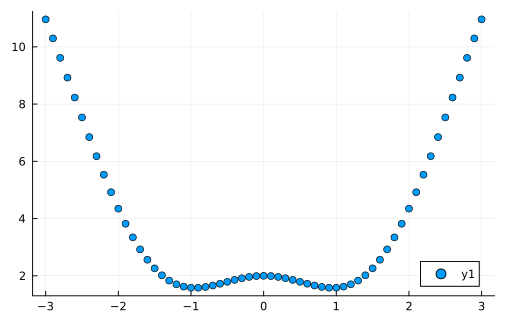

In [9]:
y = @. x^2 + 2cos(x)^2 

scatter(x, y)

In [10]:
#| output: false

model = SRRegressor(
    binary_operators = [+, -, *],    
    unary_operators = [cos],
    niterations=50,
    seed = 1
);

mach = machine(model, X, y)
fit!(mach)

[ Info: Training machine(SRRegressor(binary_operators = Function[+, -, *], …), …).
┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


0.0%┣                                             ┫ 0/750 [00:00<00:-10, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.008e+01  3.604e+01  y = 0.7132                                    2           1.965e+01  2.128e-02  y = cos(-0.68131)                             4           1.771e+01  5.196e-02  y = (cos(-0.86096) - -0.43406)                5           1.676e+00  2.358e+00  y = ((x₁ * x₁) - -2.0616)                     7           4.844e-01  6.206e-01  y = (((x₁ * x₁) - -2.0616) + -1.0825)         13          4.843e-01  2.841e-05  y = ((

2.0%┣▉                                           ┫ 15/750 [00:00<00:07, 108it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.1%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           1.513e+01  3.604e+01  y = 1.5546                                    3           1.425e+00  1.181e+00  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.760e-01  8.650e-03  y = (((x₁ * 1.0623) * x₁) + 0.73484)          8           4.114e-01  1.460e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.526e-01  1.541e-01  y = ((

4.4%┣██                                          ┫ 33/750 [00:00<00:06, 129it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.4%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           1.513e+01  3.604e+01  y = 1.5546                                    3           1.425e+00  1.181e+00  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.526e-01  1.541e-01  y = ((

5.5%┣██▍                                         ┫ 41/750 [00:00<00:06, 125it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.1%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.927e-01  4.757e-01  y = ((x₁ * (x₁ * 1.313)) + cos(x₁))           10          1.229e-31  1.802e+01  y = ((

7.2%┣███▏                                        ┫ 54/750 [00:00<00:06, 120it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.927e-01  4.757e-01  y = ((x₁ * (x₁ * 1.313)) + cos(x₁))           10          1.229e-31  1.802e+01  y = ((

8.9%┣████                                        ┫ 67/750 [00:01<00:06, 115it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.8%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

10.0%┣████▎                                      ┫ 75/750 [00:01<00:06, 116it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.8%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

12.0%┣█████▏                                     ┫ 90/750 [00:01<00:06, 117it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.9%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

14.0%┣█████▉                                    ┫ 105/750 [00:01<00:05, 119it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.9%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

15.1%┣██████▎                                   ┫ 113/750 [00:01<00:05, 119it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.7%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

17.1%┣███████▏                                  ┫ 128/750 [00:01<00:05, 119it/s]Expressions evaluated per second: 2.01e+05. Head worker occupation: 4.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

18.8%┣████████                                  ┫ 141/750 [00:01<00:05, 118it/s]Expressions evaluated per second: 2.01e+05. Head worker occupation: 4.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

19.9%┣████████▍                                 ┫ 149/750 [00:01<00:05, 119it/s]Expressions evaluated per second: 2.01e+05. Head worker occupation: 4.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

22.0%┣█████████▎                                ┫ 165/750 [00:01<00:05, 116it/s]Expressions evaluated per second: 2.01e+05. Head worker occupation: 4.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

22.8%┣█████████▉                                 ┫ 171/750 [00:02<00:06, 98it/s]Expressions evaluated per second: 2.01e+05. Head worker occupation: 4.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

23.7%┣██████████▏                                ┫ 178/750 [00:02<00:06, 88it/s]Expressions evaluated per second: 1.47e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

25.7%┣███████████                                ┫ 193/750 [00:02<00:06, 90it/s]Expressions evaluated per second: 1.47e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

27.6%┣███████████▉                               ┫ 207/750 [00:02<00:06, 91it/s]Expressions evaluated per second: 1.47e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

28.5%┣████████████▎                              ┫ 214/750 [00:02<00:06, 92it/s]Expressions evaluated per second: 1.47e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

30.5%┣█████████████▏                             ┫ 229/750 [00:02<00:06, 94it/s]Expressions evaluated per second: 1.47e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

33.1%┣██████████████▏                            ┫ 248/750 [00:03<00:05, 96it/s]Expressions evaluated per second: 1.47e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

35.6%┣███████████████▎                           ┫ 267/750 [00:03<00:05, 99it/s]Expressions evaluated per second: 1.47e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

36.8%┣███████████████▌                          ┫ 276/750 [00:03<00:05, 100it/s]Expressions evaluated per second: 1.47e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

39.3%┣████████████████▌                         ┫ 295/750 [00:03<00:04, 103it/s]Expressions evaluated per second: 1.47e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

41.7%┣█████████████████▌                        ┫ 313/750 [00:03<00:04, 104it/s]Expressions evaluated per second: 1.47e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

42.8%┣██████████████████                        ┫ 321/750 [00:03<00:04, 105it/s]Expressions evaluated per second: 1.74e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

44.9%┣██████████████████▉                       ┫ 337/750 [00:03<00:04, 106it/s]Expressions evaluated per second: 1.74e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

47.1%┣███████████████████▊                      ┫ 353/750 [00:03<00:04, 107it/s]Expressions evaluated per second: 1.74e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

48.1%┣████████████████████▏                     ┫ 361/750 [00:03<00:04, 107it/s]Expressions evaluated per second: 1.74e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

50.0%┣█████████████████████                     ┫ 375/750 [00:03<00:03, 108it/s]Expressions evaluated per second: 1.74e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

52.0%┣█████████████████████▉                    ┫ 390/750 [00:04<00:03, 108it/s]Expressions evaluated per second: 1.74e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

54.1%┣██████████████████████▊                   ┫ 406/750 [00:04<00:03, 109it/s]Expressions evaluated per second: 1.74e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

55.2%┣███████████████████████▏                  ┫ 414/750 [00:04<00:03, 109it/s]Expressions evaluated per second: 1.74e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

57.3%┣████████████████████████                  ┫ 430/750 [00:04<00:03, 110it/s]Expressions evaluated per second: 1.74e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

58.4%┣████████████████████████▌                 ┫ 438/750 [00:04<00:03, 110it/s]Expressions evaluated per second: 1.74e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

60.7%┣█████████████████████████▌                ┫ 455/750 [00:04<00:03, 111it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

62.8%┣██████████████████████████▍               ┫ 471/750 [00:04<00:02, 112it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

64.8%┣███████████████████████████▏              ┫ 486/750 [00:04<00:02, 112it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

65.9%┣███████████████████████████▋              ┫ 494/750 [00:04<00:02, 112it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

67.9%┣████████████████████████████▌             ┫ 509/750 [00:05<00:02, 113it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

70.1%┣█████████████████████████████▌            ┫ 526/750 [00:05<00:02, 113it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

71.1%┣█████████████████████████████▉            ┫ 533/750 [00:05<00:02, 113it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

72.9%┣██████████████████████████████▋           ┫ 547/750 [00:05<00:02, 113it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

74.9%┣███████████████████████████████▌          ┫ 562/750 [00:05<00:02, 113it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

76.8%┣████████████████████████████████▎         ┫ 576/750 [00:05<00:02, 113it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

77.7%┣████████████████████████████████▋         ┫ 583/750 [00:05<00:01, 114it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

79.7%┣█████████████████████████████████▌        ┫ 598/750 [00:05<00:01, 114it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

81.9%┣██████████████████████████████████▍       ┫ 614/750 [00:05<00:01, 114it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

83.9%┣███████████████████████████████████▎      ┫ 629/750 [00:05<00:01, 115it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

84.9%┣███████████████████████████████████▊      ┫ 637/750 [00:06<00:01, 115it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

87.5%┣████████████████████████████████████▊     ┫ 656/750 [00:06<00:01, 116it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

89.9%┣█████████████████████████████████████▊    ┫ 674/750 [00:06<00:01, 117it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

92.0%┣██████████████████████████████████████▋   ┫ 690/750 [00:06<00:01, 117it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

92.8%┣███████████████████████████████████████   ┫ 696/750 [00:06<00:00, 117it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

94.9%┣███████████████████████████████████████▉  ┫ 712/750 [00:06<00:00, 117it/s]Expressions evaluated per second: 1.94e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

96.1%┣████████████████████████████████████████▍ ┫ 721/750 [00:06<00:00, 117it/s]Expressions evaluated per second: 1.94e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

98.3%┣█████████████████████████████████████████▎┫ 737/750 [00:06<00:00, 117it/s]Expressions evaluated per second: 1.94e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           2.870e-01  4.954e-01  y = ((x₁ * (x₁ * 1.2949)) + cos(x₁))          10          1.229e-31  1.802e+01  y = ((

trained Machine; caches model-specific representations of data
  model: SRRegressor(binary_operators = Function[+, -, *], …)
  args: 
    1:	Source @333 ⏎ AbstractMatrix{Continuous}
    2:	Source @320 ⏎ AbstractVector{Continuous}


In [11]:
r = report(mach)
node_to_symbolic(r.equations[r.best_idx], model)

(x1 * x1) + (cos(x1 + x1) + 1.0)

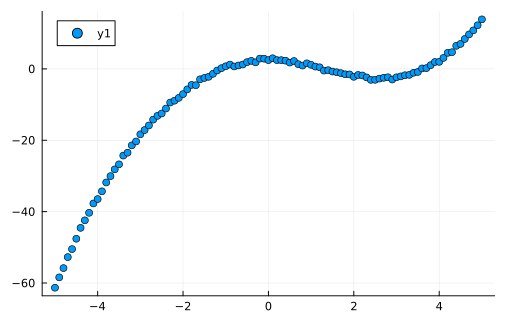

In [12]:
x = [-5:0.1:5;]
X = reshape(x, (length(x), 1))
errors = rand(length(x))
y = @. 0.3*x^3 - x^2 + 2cos(x) + errors

scatter(x, y)

In [13]:
#| output: false
model = SRRegressor(
    binary_operators = [+, -, *],    
    unary_operators = [cos],
    niterations=60,
    seed = 1
);

mach = machine(model, X, y)
fit!(mach)

[ Info: Training machine(SRRegressor(binary_operators = Function[+, -, *], …), …).
┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


0.0%┣                                              ┫ 0/900 [00:00<00:-3, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.821e+02  3.604e+01  y = x₁                                        3           2.408e+02  7.925e-02  y = (x₁ * 1.7563)                             5           2.010e+02  9.021e-02  y = ((x₁ * 1.7563) + x₁)                      7           7.261e+01  5.091e-01  y = ((x₁ + -1.1372) * (1.4796 - x₁))          9           6.827e+01  3.086e-02  y = (((x₁ + -1.1372) + -0.16409) * (1.4796 - x₁))                                     

1.9%┣▉                                           ┫ 17/900 [00:00<00:07, 127it/s]Expressions evaluated per second: [.....]. Head worker occupation: 5.2%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.821e+02  3.604e+01  y = x₁                                        3           2.033e+02  1.638e-01  y = (x₁ * 2.6847)                             5           6.824e+01  5.458e-01  y = (x₁ * (2.6495 - x₁))                      7           3.640e+01  3.142e-01  y = (x₁ * (2.6495 - (x₁ - 1.7523)))           9           3.619e+01  2.976e-03  y = (x₁ - (((x₁ - 0.54095) - 3.1615) * x₁))   11          3.097e+01  7.788e-02  y = (x

3.8%┣█▋                                          ┫ 34/900 [00:00<00:06, 134it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.6%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.818e+02  3.604e+01  y = -8.461                                    3           1.769e+02  2.328e-01  y = (x₁ * 3.8603)                             5           3.609e+01  7.948e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           9           3.294e+01  4.464e-02  y = (x₁ * (3.8603 - (x₁ - cos(cos(x₁)))))     10          2.935e+01  1.154e-01  y = (c

4.6%┣██                                          ┫ 41/900 [00:00<00:07, 131it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.3%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          2.336e+01  1.132e-01  y = (x

5.9%┣██▋                                         ┫ 53/900 [00:00<00:07, 118it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.1%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          2.075e+01  1.724e-01  y = (x

6.6%┣██▉                                         ┫ 59/900 [00:01<00:07, 115it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          2.075e+01  1.724e-01  y = (x

8.0%┣███▌                                        ┫ 72/900 [00:01<00:07, 111it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          2.014e+01  1.874e-01  y = (x

9.7%┣████▎                                       ┫ 87/900 [00:01<00:07, 112it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          1.827e+01  2.361e-01  y = (x

10.6%┣████▌                                      ┫ 95/900 [00:01<00:07, 112it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.1%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          1.827e+01  2.361e-01  y = (x

12.2%┣█████▏                                    ┫ 110/900 [00:01<00:07, 113it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.8%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          1.827e+01  2.361e-01  y = (x

13.9%┣█████▉                                    ┫ 125/900 [00:01<00:07, 114it/s]Expressions evaluated per second: 1.93e+05. Head worker occupation: 4.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          1.827e+01  2.361e-01  y = (x

14.7%┣██████▏                                   ┫ 132/900 [00:01<00:07, 114it/s]Expressions evaluated per second: 1.93e+05. Head worker occupation: 4.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          1.827e+01  2.361e-01  y = (x

16.3%┣██████▉                                   ┫ 147/900 [00:01<00:07, 115it/s]Expressions evaluated per second: 1.93e+05. Head worker occupation: 4.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          1.827e+01  2.361e-01  y = (x

18.1%┣███████▋                                  ┫ 163/900 [00:01<00:06, 116it/s]Expressions evaluated per second: 1.93e+05. Head worker occupation: 4.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          1.827e+01  2.361e-01  y = (x

18.9%┣████████                                  ┫ 170/900 [00:01<00:06, 116it/s]Expressions evaluated per second: 1.93e+05. Head worker occupation: 4.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          1.827e+01  2.361e-01  y = (x

20.4%┣████████▋                                 ┫ 184/900 [00:02<00:06, 116it/s]Expressions evaluated per second: 1.93e+05. Head worker occupation: 4.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          1.827e+01  2.361e-01  y = (x

22.1%┣█████████▎                                ┫ 199/900 [00:02<00:06, 116it/s]Expressions evaluated per second: 1.93e+05. Head worker occupation: 4.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         10          1.827e+01  2.361e-01  y = (x

22.9%┣█████████▋                                ┫ 206/900 [00:02<00:06, 116it/s]Expressions evaluated per second: 1.93e+05. Head worker occupation: 4.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.821e+00  2.778e+00  y = (x

24.4%┣██████████▎                               ┫ 220/900 [00:02<00:06, 116it/s]Expressions evaluated per second: 1.93e+05. Head worker occupation: 4.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

26.1%┣███████████                               ┫ 235/900 [00:02<00:06, 115it/s]Expressions evaluated per second: 1.97e+05. Head worker occupation: 4.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

27.0%┣███████████▍                              ┫ 243/900 [00:02<00:06, 116it/s]Expressions evaluated per second: 1.97e+05. Head worker occupation: 4.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

28.7%┣████████████                              ┫ 258/900 [00:02<00:06, 116it/s]Expressions evaluated per second: 1.97e+05. Head worker occupation: 4.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

29.6%┣████████████▍                             ┫ 266/900 [00:02<00:05, 116it/s]Expressions evaluated per second: 1.97e+05. Head worker occupation: 4.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

31.1%┣█████████████                             ┫ 280/900 [00:02<00:05, 116it/s]Expressions evaluated per second: 1.97e+05. Head worker occupation: 4.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

32.0%┣█████████████▍                            ┫ 288/900 [00:02<00:05, 116it/s]Expressions evaluated per second: 1.97e+05. Head worker occupation: 4.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

32.8%┣█████████████▊                            ┫ 295/900 [00:03<00:05, 114it/s]Expressions evaluated per second: 1.97e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

34.6%┣██████████████▌                           ┫ 311/900 [00:03<00:06, 106it/s]Expressions evaluated per second: 1.97e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

36.1%┣███████████████▏                          ┫ 325/900 [00:03<00:05, 106it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

37.8%┣███████████████▉                          ┫ 340/900 [00:03<00:05, 107it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

38.6%┣████████████████▏                         ┫ 347/900 [00:03<00:05, 107it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

40.1%┣████████████████▉                         ┫ 361/900 [00:03<00:05, 108it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

41.7%┣█████████████████▌                        ┫ 375/900 [00:03<00:05, 108it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

42.4%┣█████████████████▉                        ┫ 382/900 [00:04<00:05, 108it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

44.1%┣██████████████████▌                       ┫ 397/900 [00:04<00:05, 108it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

45.7%┣███████████████████▏                      ┫ 411/900 [00:04<00:05, 108it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

46.6%┣███████████████████▌                      ┫ 419/900 [00:04<00:04, 108it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

48.2%┣████████████████████▎                     ┫ 434/900 [00:04<00:04, 109it/s]Expressions evaluated per second: 1.83e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

49.8%┣█████████████████████                     ┫ 448/900 [00:04<00:04, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

50.6%┣█████████████████████▎                    ┫ 455/900 [00:04<00:04, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

52.2%┣██████████████████████                    ┫ 470/900 [00:04<00:04, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

52.9%┣██████████████████████▏                   ┫ 476/900 [00:04<00:04, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

54.6%┣███████████████████████                   ┫ 491/900 [00:04<00:04, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

56.1%┣███████████████████████▋                  ┫ 505/900 [00:05<00:04, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

56.8%┣███████████████████████▉                  ┫ 511/900 [00:05<00:04, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

58.2%┣████████████████████████▌                 ┫ 524/900 [00:05<00:03, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

59.1%┣████████████████████████▉                 ┫ 532/900 [00:05<00:03, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

60.8%┣█████████████████████████▌                ┫ 547/900 [00:05<00:03, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

61.6%┣█████████████████████████▉                ┫ 554/900 [00:05<00:03, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

63.2%┣██████████████████████████▌               ┫ 569/900 [00:05<00:03, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

64.7%┣███████████████████████████▏              ┫ 582/900 [00:05<00:03, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

66.2%┣███████████████████████████▉              ┫ 596/900 [00:05<00:03, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

67.0%┣████████████████████████████▏             ┫ 603/900 [00:06<00:03, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

68.4%┣████████████████████████████▊             ┫ 616/900 [00:06<00:03, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

69.2%┣█████████████████████████████             ┫ 623/900 [00:06<00:03, 109it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

70.6%┣█████████████████████████████▋            ┫ 635/900 [00:06<00:02, 108it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

72.0%┣██████████████████████████████▎           ┫ 648/900 [00:06<00:02, 108it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

72.8%┣██████████████████████████████▋           ┫ 655/900 [00:06<00:02, 108it/s]Expressions evaluated per second: 1.88e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

74.1%┣███████████████████████████████▏          ┫ 667/900 [00:06<00:02, 108it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

75.4%┣███████████████████████████████▊          ┫ 679/900 [00:06<00:02, 108it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x₁ * (((x₁ * 0.30037) + -1.0238) * x₁))  11          1.546e+00  7.638e-02  y = ((

77.6%┣████████████████████████████████▋         ┫ 698/900 [00:06<00:02, 108it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

79.0%┣█████████████████████████████████▏        ┫ 711/900 [00:07<00:02, 108it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

79.7%┣█████████████████████████████████▌        ┫ 717/900 [00:07<00:02, 107it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

81.0%┣██████████████████████████████████        ┫ 729/900 [00:07<00:02, 107it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

82.6%┣██████████████████████████████████▊       ┫ 743/900 [00:07<00:01, 107it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

83.2%┣███████████████████████████████████       ┫ 749/900 [00:07<00:01, 107it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

84.6%┣███████████████████████████████████▌      ┫ 761/900 [00:07<00:01, 107it/s]Expressions evaluated per second: 1.85e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

86.1%┣████████████████████████████████████▏     ┫ 775/900 [00:07<00:01, 107it/s]Expressions evaluated per second: 1.85e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

86.8%┣████████████████████████████████████▌     ┫ 781/900 [00:07<00:01, 107it/s]Expressions evaluated per second: 1.85e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

88.2%┣█████████████████████████████████████     ┫ 794/900 [00:07<00:01, 107it/s]Expressions evaluated per second: 1.85e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

89.0%┣█████████████████████████████████████▍    ┫ 801/900 [00:07<00:01, 107it/s]Expressions evaluated per second: 1.85e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

90.4%┣██████████████████████████████████████    ┫ 814/900 [00:08<00:01, 107it/s]Expressions evaluated per second: 1.85e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

91.9%┣██████████████████████████████████████▋   ┫ 827/900 [00:08<00:01, 106it/s]Expressions evaluated per second: 1.85e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

92.7%┣███████████████████████████████████████   ┫ 834/900 [00:08<00:01, 106it/s]Expressions evaluated per second: 1.85e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

94.2%┣███████████████████████████████████████▋  ┫ 848/900 [00:08<00:00, 106it/s]Expressions evaluated per second: 1.85e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

95.0%┣████████████████████████████████████████  ┫ 855/900 [00:08<00:00, 106it/s]Expressions evaluated per second: 1.85e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

96.3%┣████████████████████████████████████████▌ ┫ 867/900 [00:08<00:00, 106it/s]Expressions evaluated per second: 1.84e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

97.9%┣█████████████████████████████████████████▏┫ 881/900 [00:08<00:00, 106it/s]Expressions evaluated per second: 1.84e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

98.4%┣█████████████████████████████████████████▍┫ 886/900 [00:08<00:00, 106it/s]Expressions evaluated per second: 1.84e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.817e+02  3.604e+01  y = -8.3654                                   3           1.723e+02  2.459e-01  y = (x₁ * 4.5943)                             5           3.609e+01  7.817e-01  y = (x₁ * (4.5943 - x₁))                      7           3.601e+01  1.020e-03  y = (x₁ * (4.5943 - (x₁ * 1.0238)))           8           2.930e+01  2.064e-01  y = (x₁ * (cos(x₁) - (x₁ + -5.0333)))         9           1.801e+00  2.789e+00  y = (x

trained Machine; caches model-specific representations of data
  model: SRRegressor(binary_operators = Function[+, -, *], …)
  args: 
    1:	Source @522 ⏎ AbstractMatrix{Continuous}
    2:	Source @268 ⏎ AbstractVector{Continuous}


In [14]:
r = report(mach)
node_to_symbolic(r.equations[r.best_idx], model)

((x1 * (((x1 * 0.3003694595536163) + -0.9981039812798387) * x1)) - -0.4976243988623521) - (cos(x1) * -2.028519160892326)

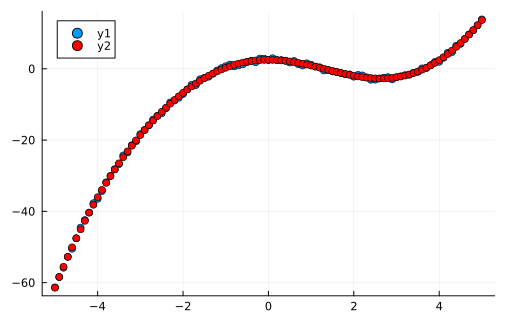

In [15]:
y_pred = predict(mach, X)
 
scatter(x, y);
scatter!(x, y_pred, color = "red")